In [1]:
# Description: Plot Figure 2 (Surface velocity profiles and jet widt-deformation radius scatterplots).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        July/2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from xarray import open_dataset, DataArray
from hdf5storage import loadmat
from ap_tools.stats import rsig_student, rci_fisher, arsig
from ap_tools.utils import near, lon180to360
from scipy.interpolate import griddata
from gsw import f as fcor

In [3]:
def arsig_student(r0, Ndt, T1, T2, verbose=True):
    r0 = np.abs(r0)
    Tslow = np.maximum(T1, T2) # The effective number of
    edof = Ndt/Tslow           # DoFs is constrained by the
                               # slower-decorrelating variable.
    alphai = 0.51
    issig = True
    while issig and alphai<1.0:
        rsigi = rsig_student(edof, alpha=alphai)
        issig=r0>=rsigi
        alphai+=0.01

    if verbose:
        print("Queried r = %.3f with %.1f EDoF. It is significant at **%.2f** CL."%(r0, edof, alphai))

    return alphai

In [4]:
def get_corrstr(x, y):
    r = np.corrcoef(x, y)[0][1]
    dof = len(x)
    p = arsig_student(r, dof, 1, 1, verbose=True)
    rci_fisher(r, dof, alpha=0.95)
    s = "$r$ = %.2f"%r

    return s

In [5]:
head_deriv = "../../data/derived/"
fnames = ["GulfStream33N", "GulfStream34N", "GulfStream36N", "GulfStream37N", "GulfStream38N", "AgulhasCurrent", "EAC29S", "BrazilCurrent29S", "KuroshioCurrent25N", "KuroshioCurrent28p5N", "SAFjet", "PFjet", "SACCFjet", "LMGshfbrk"]
ACCjets = ["SAFjet", "PFjet", "SACCFjet"]
ADCPjets = ["SAFjet", "PFjet", "SACCFjet", "LMGshfbrk"]
synop_names = ["BC", "ACsouth", "ACnorth", "GC"]
ufrac = 0.5

Lmaxlr = 80
Lmax = 160

In [6]:
xss, uss, cols, linestyles = [], [], [], []
for f in fnames:
    d = np.load(head_deriv + f + ".npz")
    x, us = d["x"], d["us"]

    if f in ACCjets:
        linestyles.append("dashed")
    else:
        linestyles.append("solid")

    if f in ADCPjets:
        cols.append("m")
    else:
        cols.append("k")

    xss.append(x)
    uss.append(us)

In [7]:
fnames = ["GulfStream33N", "GulfStream34N", "GulfStream36N", "GulfStream37N", "GulfStream38N", "AgulhasCurrent", "EAC29S", "BrazilCurrent29S", "KuroshioCurrent25N", "KuroshioCurrent28p5N", "LMGshfbrk", "SAFjet", "PFjet", "SACCFjet", "GC", "ACsouth", "ACnorth", "BC"]

Ldls_flat, Ldrs_flat, Ldls_surf, Ldrs_surf, Ljls, Ljrs = [], [], [], [], [], []
Ldls_flat_synop, Ldrs_flat_synop, Ldls_surf_synop, Ldrs_surf_synop, Ljls_synop, Ljrs_synop = [], [], [], [], [], []
Ldls_flat_ACC, Ldrs_flat_ACC, Ldls_surf_ACC, Ldrs_surf_ACC, Ljls_ACC, Ljrs_ACC = [], [], [], [], [], []
Ldls_flat_stream, Ldrs_flat_stream, Ldls_surf_stream, Ldrs_surf_stream, Ljls_stream, Ljrs_stream = [], [], [], [], [], []
for f in fnames:
    f = head_deriv + f + ".npz"
    d = np.load(f, allow_pickle=True)
    Ldlsurf, Ldrsurf = d["Ldlsurf"], d["Ldrsurf"]
    Ldlflat, Ldrflat = d["Ldlflat"], d["Ldrflat"]
    Ljl, Ljr = np.abs(d["Ljlufrac"].flatten()[0][ufrac]), np.abs(d["Ljrufrac"].flatten()[0][ufrac])
    
    Ldls_flat.append(Ldlflat)
    Ldrs_flat.append(Ldrflat)
    Ldls_surf.append(Ldlsurf)
    Ldrs_surf.append(Ldrsurf)
    Ljls.append(Ljl)
    Ljrs.append(Ljr)
    
    fshort = f.split("/")[-1].split(".")[0]
    if fshort in synop_names:
        Ldls_flat_synop.append(Ldlflat)
        Ldrs_flat_synop.append(Ldrflat)
        Ldls_surf_synop.append(Ldlsurf)
        Ldrs_surf_synop.append(Ldrsurf)
        Ljls_synop.append(Ljl)
        Ljrs_synop.append(Ljr)
    elif fshort in ACCjets:
        Ldls_flat_ACC.append(Ldlflat)
        Ldrs_flat_ACC.append(Ldrflat)
        Ldls_surf_ACC.append(Ldlsurf)
        Ldrs_surf_ACC.append(Ldrsurf)
        Ljls_ACC.append(Ljl)
        Ljrs_ACC.append(Ljr)
    else:
        Ldls_flat_stream.append(Ldlflat)
        Ldrs_flat_stream.append(Ldrflat)
        Ldls_surf_stream.append(Ldlsurf)
        Ldrs_surf_stream.append(Ldrsurf)
        Ljls_stream.append(Ljl)
        Ljrs_stream.append(Ljr)

### Add Florida Current and East Australian Current from Archer et al. (2018).

In [8]:
dA18_FC = np.load(head_deriv + "digitize_EACFC_Archer_etal2018/FC_archeretal2018.npz", allow_pickle=True)

Ljl_A18FC, Ljr_A18FC = np.abs(dA18_FC["Ljlufrac"].flatten()[0][ufrac]), np.abs(dA18_FC["Ljrufrac"].flatten()[0][ufrac])
Ldl_flat_A18FC, Ldr_flat_A18FC = dA18_FC["Ldlflat"], dA18_FC["Ldrflat"]
Ldl_surf_A18FC, Ldr_surf_A18FC = dA18_FC["Ldlsurf"], dA18_FC["Ldrsurf"]

dA18_EAC = np.load(head_deriv + "digitize_EACFC_Archer_etal2018/EAC_archeretal2018.npz", allow_pickle=True)

Ljl_A18EAC, Ljr_A18EAC = np.abs(dA18_EAC["Ljlufrac"].flatten()[0][ufrac]), np.abs(dA18_EAC["Ljrufrac"].flatten()[0][ufrac])
Ldl_flat_A18EAC, Ldr_flat_A18EAC = dA18_EAC["Ldlflat"], dA18_EAC["Ldrflat"]
Ldl_surf_A18EAC, Ldr_surf_A18EAC = dA18_EAC["Ldlsurf"], dA18_EAC["Ldrsurf"]

Ldls_flat.append(Ldl_flat_A18FC)
Ldrs_flat.append(Ldr_flat_A18FC)
Ldls_surf.append(Ldl_surf_A18FC)
Ldrs_surf.append(Ldr_surf_A18FC)
Ljls.append(Ljl_A18FC)
Ljrs.append(Ljr_A18FC)

Lj_A18FC = Ljl_A18FC + Ljr_A18FC
Ld_flat_A18FC = Ldl_flat_A18FC + Ldr_flat_A18FC
Ld_surf_A18FC = Ldl_surf_A18FC + Ldr_surf_A18FC

Ldls_flat.append(Ldl_flat_A18EAC)
Ldrs_flat.append(Ldr_flat_A18EAC)
Ldls_surf.append(Ldl_surf_A18EAC)
Ldrs_surf.append(Ldr_surf_A18EAC)
Ljls.append(Ljl_A18EAC)
Ljrs.append(Ljr_A18EAC)

Lj_A18EAC = Ljl_A18EAC + Ljr_A18EAC
Ld_flat_A18EAC = Ldl_flat_A18EAC + Ldr_flat_A18EAC
Ld_surf_A18EAC = Ldl_surf_A18EAC + Ldr_surf_A18EAC

### Add Gulf Stream from Rossby & Zhang (2001).

In [9]:
dRZ01_GS = np.load(head_deriv + "digitize_GS_Rossby_Zhang2001/GS_rossbyzhang2001.npz", allow_pickle=True)

Ljl_RSZ01, Ljr_RSZ01 = np.abs(dRZ01_GS["Ljlufrac"].flatten()[0][ufrac]), np.abs(dRZ01_GS["Ljrufrac"].flatten()[0][ufrac])
Ldl_flat_RSZ01, Ldr_flat_RSZ01 = dRZ01_GS["Ldlflat"], dRZ01_GS["Ldrflat"]
Ldl_surf_RSZ01, Ldr_surf_RSZ01 = dRZ01_GS["Ldlsurf"], dRZ01_GS["Ldrsurf"]

Ldls_flat.append(Ldl_flat_RSZ01)
Ldrs_flat.append(Ldr_flat_RSZ01)
Ldls_surf.append(Ldl_surf_RSZ01)
Ldrs_surf.append(Ldr_surf_RSZ01)
Ljls.append(Ljl_RSZ01)
Ljrs.append(Ljr_RSZ01)
Lj_RSZ01 = Ljl_RSZ01 + Ljr_RSZ01
Ld_flat_RSZ01 = Ldl_flat_RSZ01 + Ldr_flat_RSZ01
Ld_surf_RSZ01 = Ldl_surf_RSZ01 + Ldr_surf_RSZ01

Ldls_surf, Ldrs_surf, Ldls_flat, Ldrs_flat, Ljls, Ljrs = map(np.array, (Ldls_surf, Ldrs_surf, Ldls_flat, Ldrs_flat, Ljls, Ljrs))
Lds_surf = Ldls_surf + Ldrs_surf
Lds_flat = Ldls_flat + Ldrs_flat
Ljs = Ljls + Ljrs

Ldls_surf_synop, Ldrs_surf_synop, Ldls_flat_synop, Ldrs_flat_synop, Ljls_synop, Ljrs_synop = map(np.array, (Ldls_surf_synop, Ldrs_surf_synop, Ldls_flat_synop, Ldrs_flat_synop, Ljls_synop, Ljrs_synop))
Lds_surf_synop = Ldls_surf_synop + Ldrs_surf_synop
Lds_flat_synop = Ldls_flat_synop + Ldrs_flat_synop
Ljs_synop = Ljls_synop + Ljrs_synop

Ldls_surf_ACC, Ldrs_surf_ACC, Ldls_flat_ACC, Ldrs_flat_ACC, Ljls_ACC, Ljrs_ACC = map(np.array, (Ldls_surf_ACC, Ldrs_surf_ACC, Ldls_flat_ACC, Ldrs_flat_ACC, Ljls_ACC, Ljrs_ACC))
Lds_surf_ACC = Ldls_surf_ACC + Ldrs_surf_ACC
Lds_flat_ACC = Ldls_flat_ACC + Ldrs_flat_ACC
Ljs_ACC = Ljls_ACC + Ljrs_ACC

Ldls_surf_stream, Ldrs_surf_stream, Ldls_flat_stream, Ldrs_flat_stream, Ljls_stream, Ljrs_stream = map(np.array, (Ldls_surf_stream, Ldrs_surf_stream, Ldls_flat_stream, Ldrs_flat_stream, Ljls_stream, Ljrs_stream))
Lds_surf_stream = Ldls_surf_stream + Ldrs_surf_stream
Lds_flat_stream = Ldls_flat_stream + Ldrs_flat_stream
Ljs_stream = Ljls_stream + Ljrs_stream

### Plot all time-averaged jet profiles and the jet width-deformation radius scatterplots.

Queried r = 0.481 with 21.0 EDoF. It is significant at **1.00** CL.

Fisher transform CI (xl,xu): (0.062,0.756)

Queried r = 0.443 with 21.0 EDoF. It is significant at **0.99** CL.

Fisher transform CI (xl,xu): (0.014,0.734)

Queried r = 0.526 with 21.0 EDoF. It is significant at **1.00** CL.

Fisher transform CI (xl,xu): (0.122,0.780)

Queried r = 0.553 with 21.0 EDoF. It is significant at **1.00** CL.

Fisher transform CI (xl,xu): (0.160,0.795)

Queried r = 0.442 with 21.0 EDoF. It is significant at **0.99** CL.

Fisher transform CI (xl,xu): (0.012,0.734)

Queried r = 0.559 with 21.0 EDoF. It is significant at **1.00** CL.

Fisher transform CI (xl,xu): (0.168,0.798)



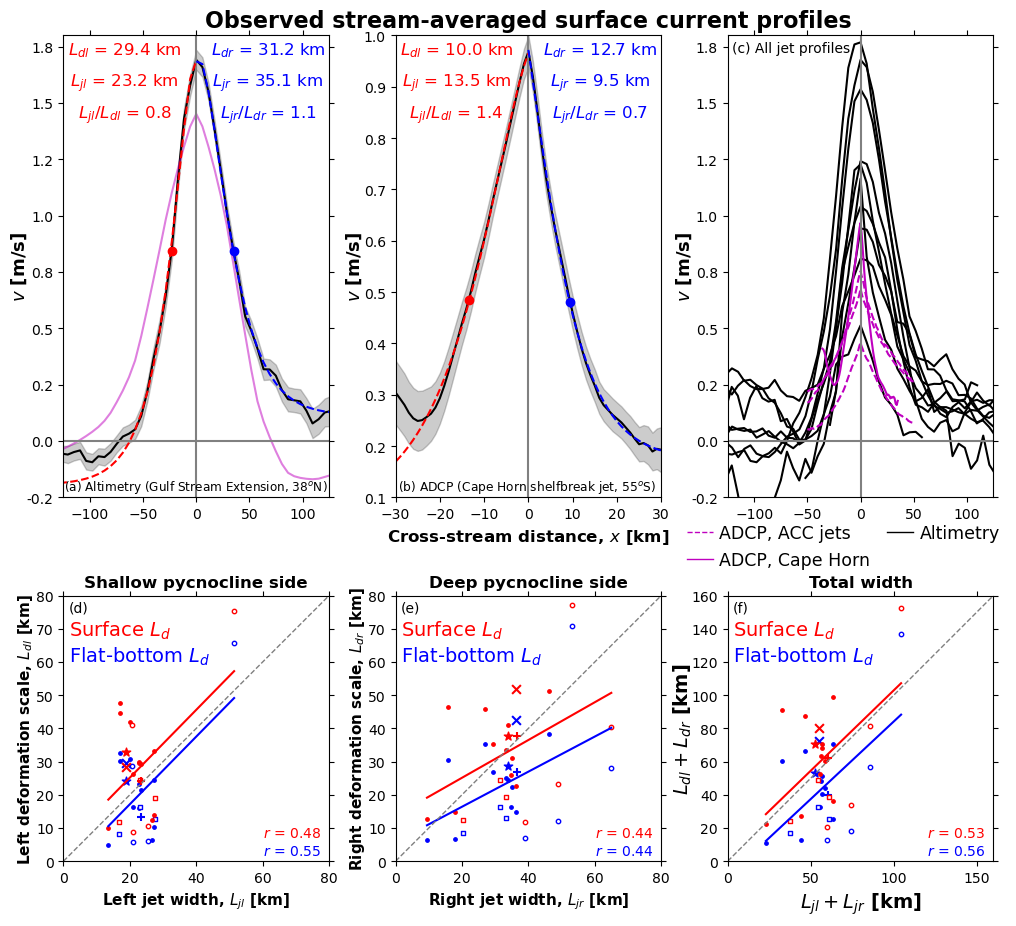

In [10]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 12))
ax1, ax2, ax3 = ax[0]
ax4, ax5, ax6 = ax[1]

###### Jet profiles (panels a, b, c).

# (a) Gulf Stream Extension jet example.
xlabel = "Cross-stream distance, $x$ [km]"

d = np.load(head_deriv + "GulfStream38N.npz", allow_pickle=True)
xs = d["x"]
us = d["us"]
Ldlsurf, Ldrsurf = d["Ldlsurf"], d["Ldrsurf"]
Ldlflat, Ldrflat = d["Ldlflat"], d["Ldrflat"]
Ljl, Ljr = d["Ljlufrac"].flatten()[0][ufrac], d["Ljrufrac"].flatten()[0][ufrac]
xpl, ypl = d["xpl"], d["ypl"]
xpr, ypr = d["xpr"], d["ypr"]
vADT = d["vADT"]

CL95l, CL95u = d["CL95l"], d["CL95u"]
cl, cr = "r", "b"
cl2, cr2 = "r--", "b--"

ax1.plot(xs, us, "k")
ax1.plot(xs, vADT, "m", alpha=0.5)
ax1.fill_between(xs, CL95l, CL95u, color="k", alpha=0.2)
ax1.axhline(color="gray", linestyle="solid")
ax1.axvline(color="gray", linestyle="solid")

xsmin = -np.maximum(-xs[0], xs[-1])
xsaux = np.linspace(xsmin, 0, num=1000)
xsaux = np.hstack((xsaux, np.flipud(-xsaux)[1:]))
usaux = np.interp(xsaux, xs, us, left=np.nan, right=np.nan)

usl = usaux[near(xsaux, Ljl, return_index=True)]
usr = usaux[near(xsaux, Ljr, return_index=True)]
ax1.plot(Ljl, usl, marker="o", ms=6, mfc="r", mec="r")
ax1.plot(Ljr, usr, marker="o", ms=6, mfc="b", mec="b")
Ljl = -Ljl # For text annotation.

xannotl, xannotr = 0.23, 0.77
fsannot = 12
dyt = 0.21
ax1.text(xannotl, 0.75+dyt, "$L_{dl}$ = %.1f km"%Ldlsurf, fontsize=fsannot, transform=ax1.transAxes, ha="center", color=cl)
ax1.text(xannotr, 0.75+dyt, "$L_{dr}$ = %.1f km"%Ldrsurf, fontsize=fsannot, transform=ax1.transAxes, ha="center", color=cr)
ax1.plot(xpl, ypl, cl2)
ax1.plot(xpr, ypr, cr2)
ax1.text(xannotl, 0.68+dyt, "$L_{jl}$ = %.1f km"%Ljl, fontsize=fsannot, transform=ax1.transAxes, ha="center", color=cl)
ax1.text(xannotr, 0.68+dyt, "$L_{jr}$ = %.1f km"%Ljr, fontsize=fsannot, transform=ax1.transAxes, ha="center", color=cr)
ax1.text(xannotl, 0.61+dyt, "$L_{jl}/L_{dl}$ = %.1f"%(Ljl/Ldlsurf), fontsize=fsannot, transform=ax1.transAxes, ha="center", color=cl)
ax1.text(xannotr, 0.61+dyt, "$L_{jr}/L_{dr}$ = %.1f"%(Ljr/Ldrsurf), fontsize=fsannot, transform=ax1.transAxes, ha="center", color=cr)

ax1.set_ylabel("$v$ [m/s]", fontsize=13, fontweight="black", labelpad=-2)

# (b) Shipboard jet example.
d = np.load(head_deriv + "LMGshfbrk.npz", allow_pickle=True)
xs = d["x"]
us = d["us"]
Ldlsurf, Ldrsurf = d["Ldlsurf"], d["Ldrsurf"]
Ldlflat, Ldrflat = d["Ldlflat"], d["Ldrflat"]
Ljl, Ljr = d["Ljlufrac"].flatten()[0][ufrac], d["Ljrufrac"].flatten()[0][ufrac]
xpl, ypl = d["xpl"], d["ypl"]
xpr, ypr = d["xpr"], d["ypr"]
CL95l, CL95u = d["CL95l"], d["CL95u"]

ax2.plot(xs, us, "k")
ax2.fill_between(xs, CL95l, CL95u, color="k", alpha=0.2)
ax2.axhline(color="gray", linestyle="solid")
ax2.axvline(color="gray", linestyle="solid")

xsmin = -np.maximum(-xs[0], xs[-1])
xsaux = np.linspace(xsmin, 0, num=1000)
xsaux = np.hstack((xsaux, np.flipud(-xsaux)[1:]))
usaux = np.interp(xsaux, xs, us, left=np.nan, right=np.nan)

usl = usaux[near(xsaux, Ljl, return_index=True)]
usr = usaux[near(xsaux, Ljr, return_index=True)]
ax2.plot(Ljl, usl, marker="o", ms=6, mfc="r", mec="r")
ax2.plot(Ljr, usr, marker="o", ms=6, mfc="b", mec="b")
Ljl = -Ljl # For text annotation.

ax2.text(xannotl, 0.75+dyt, "$L_{dl}$ = %.1f km"%Ldlsurf, fontsize=fsannot, transform=ax2.transAxes, ha="center", color=cl)
ax2.text(xannotr, 0.75+dyt, "$L_{dr}$ = %.1f km"%Ldrsurf, fontsize=fsannot, transform=ax2.transAxes, ha="center", color=cr)
ax2.plot(xpl, ypl, cl2)
ax2.plot(xpr, ypr, cr2)
ax2.text(xannotl, 0.68+dyt, "$L_{jl}$ = %.1f km"%Ljl, fontsize=fsannot, transform=ax2.transAxes, ha="center", color=cl)
ax2.text(xannotr, 0.68+dyt, "$L_{jr}$ = %.1f km"%Ljr, fontsize=fsannot, transform=ax2.transAxes, ha="center", color=cr)
ax2.text(xannotl, 0.61+dyt, "$L_{jl}/L_{dl}$ = %.1f"%(Ljl/Ldlsurf), fontsize=fsannot, transform=ax2.transAxes, ha="center", color=cl)
ax2.text(xannotr, 0.61+dyt, "$L_{jr}/L_{dr}$ = %.1f"%(Ljr/Ldrsurf), fontsize=fsannot, transform=ax2.transAxes, ha="center", color=cr)

ax2.set_xlabel(xlabel, fontsize=12, fontweight="black")
ax2.set_ylabel("$v$ [m/s]", fontsize=13, fontweight="black", labelpad=0)

for xs, us, col, ls in zip(xss, uss, cols, linestyles):
    ax3.plot(xs, us, color=col, linestyle=ls)

xclip = 125
xclip2 = 30
minuclip = -0.25
maxuclip = 1.8
ax1.set_xlim(-xclip, xclip)
ax1.set_ylim(minuclip, maxuclip)
ax2.set_xlim(-xclip2, xclip2)
ax2.set_ylim(0.1, 1)
ax3.set_xlim(-xclip, xclip)
ax3.set_ylim(minuclip, maxuclip)
ax3.axhline(color="gray", linestyle="solid")
ax3.axvline(color="gray", linestyle="solid")
ffmt = FormatStrFormatter('%.1f')
ax1.yaxis.set_major_formatter(ffmt)
ax2.yaxis.set_major_formatter(ffmt)
ax3.yaxis.set_major_formatter(ffmt)
ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax3.tick_params(bottom=True, top=True, left=True, right=True)
ax3.tick_params(bottom=True, top=True, left=True, right=True)
ax3.set_ylabel("$v$ [m/s]", fontsize=13, fontweight="black", labelpad=-2)

xd, yd = [np.nan], [np.nan]
h1 = Line2D(xd, yd, color="k", linestyle="solid", linewidth=1)
h2 = Line2D(xd, yd, color="m", linestyle="solid", linewidth=1)
h3 = Line2D(xd, yd, color="m", linestyle="dashed", linewidth=1)

hs = [h1, h2, h3]
labs = ["Altimetry", "ADCP, Cape Horn", "ADCP, ACC jets"]
ax3.legend(hs, labs, fontsize=12.5, frameon=False, reverse=True, ncol=2, columnspacing=1, loc=(-0.18, -0.17), handlelength=1.5, handletextpad=0.35)

xt, yt, yt2 = 0.015, 0.95, 0.015
ax1.text(xt-0.013, yt2, "(a) Altimetry (Gulf Stream Extension, 38$^o$N)", fontsize=8.7, transform=ax1.transAxes)
ax2.text(xt-0.005, yt2, "(b) ADCP (Cape Horn shelfbreak jet, 55$^o$S)", fontsize=8.8, transform=ax2.transAxes)
ax3.text(xt, yt+0.015, "(c) All jet profiles", fontsize=10, transform=ax3.transAxes)

ax2.set_title("Observed stream-averaged surface current profiles", fontsize=16, fontweight="black")

###### Scatterplots (panels c, d, e).
cflat, csurf = "b", "r"

xLjls = [Ljls.min(), Ljls.max()]
xLjrs = [Ljrs.min(), Ljrs.max()]
xLjs = [Ljs.min(), Ljs.max()]

Ldls_flat_fit = np.polyval(np.polyfit(Ljls, Ldls_flat, 1), xLjls)
Ldrs_flat_fit = np.polyval(np.polyfit(Ljrs, Ldrs_flat, 1), xLjrs)
Lds_flat_fit = np.polyval(np.polyfit(Ljs, Lds_flat, 1), xLjs)

ax4.scatter(Ljls_stream, Ldls_flat_stream, c=cflat, s=6)
ax5.scatter(Ljrs_stream, Ldrs_flat_stream, c=cflat, s=6)
ax6.scatter(Ljs_stream, Lds_flat_stream, c=cflat, s=6)

ax4.scatter(Ljls_synop, Ldls_flat_synop, c="w", s=10, marker="o", edgecolors=cflat)
ax5.scatter(Ljrs_synop, Ldrs_flat_synop, c="w", s=10, marker="o", edgecolors=cflat)
ax6.scatter(Ljs_synop, Lds_flat_synop, c="w", s=10, marker="o", edgecolors=cflat)

ax4.scatter(Ljls_ACC, Ldls_flat_ACC, c="w", s=10, marker="s", edgecolors=cflat)
ax5.scatter(Ljrs_ACC, Ldrs_flat_ACC, c="w", s=10, marker="s", edgecolors=cflat)
ax6.scatter(Ljs_ACC, Lds_flat_ACC, c="w", s=10, marker="s", edgecolors=cflat)

ax4.scatter(Ljl_RSZ01, Ldl_flat_RSZ01, c=cflat, s=40, marker="*")
ax5.scatter(Ljr_RSZ01, Ldr_flat_RSZ01, c=cflat, s=40, marker="*")
ax6.scatter(Lj_RSZ01, Ld_flat_RSZ01, c=cflat, s=40, marker="*")

ax4.scatter(Ljl_A18FC, Ldl_flat_A18FC, c=cflat, s=40, marker="+")
ax5.scatter(Ljr_A18FC, Ldr_flat_A18FC, c=cflat, s=40, marker="+")
ax6.scatter(Lj_A18FC, Ld_flat_A18FC, c=cflat, s=40, marker="+")

ax4.scatter(Ljl_A18EAC, Ldl_flat_A18EAC, c=cflat, s=40, marker="x")
ax5.scatter(Ljr_A18EAC, Ldr_flat_A18EAC, c=cflat, s=40, marker="x")
ax6.scatter(Lj_A18EAC, Ld_flat_A18EAC, c=cflat, s=40, marker="x")

ax4.plot(xLjls, Ldls_flat_fit, cflat)
ax5.plot(xLjrs, Ldrs_flat_fit, cflat)
ax6.plot(xLjs, Lds_flat_fit, cflat)

Ldls_surf_fit = np.polyval(np.polyfit(Ljls, Ldls_surf, 1), xLjls)
Ldrs_surf_fit = np.polyval(np.polyfit(Ljrs, Ldrs_surf, 1), xLjrs)
Lds_surf_fit = np.polyval(np.polyfit(Ljs, Lds_surf, 1), xLjs)

ax4.scatter(Ljls_stream, Ldls_surf_stream, c=csurf, s=6)
ax5.scatter(Ljrs_stream, Ldrs_surf_stream, c=csurf, s=6)
ax6.scatter(Ljs_stream, Lds_surf_stream, c=csurf, s=6)

ax4.scatter(Ljls_synop, Ldls_surf_synop, c="w", s=10, marker="o", edgecolors=csurf)
ax5.scatter(Ljrs_synop, Ldrs_surf_synop, c="w", s=10, marker="o", edgecolors=csurf)
ax6.scatter(Ljs_synop, Lds_surf_synop, c="w", s=10, marker="o", edgecolors=csurf)

ax4.scatter(Ljls_ACC, Ldls_surf_ACC, c="w", s=10, marker="s", edgecolors=csurf)
ax5.scatter(Ljrs_ACC, Ldrs_surf_ACC, c="w", s=10, marker="s", edgecolors=csurf)
ax6.scatter(Ljs_ACC, Lds_surf_ACC, c="w", s=10, marker="s", edgecolors=csurf)

ax4.scatter(Ljl_RSZ01, Ldl_surf_RSZ01, c=csurf, s=40, marker="*")
ax5.scatter(Ljr_RSZ01, Ldr_surf_RSZ01, c=csurf, s=40, marker="*")
ax6.scatter(Lj_RSZ01, Ld_surf_RSZ01, c=csurf, s=40, marker="*")

ax4.scatter(Ljl_A18FC, Ldl_surf_A18FC, c=csurf, s=40, marker="+")
ax5.scatter(Ljr_A18FC, Ldr_surf_A18FC, c=csurf, s=40, marker="+")
ax6.scatter(Lj_A18FC, Ld_surf_A18FC, c=csurf, s=40, marker="+")

ax4.scatter(Ljl_A18EAC, Ldl_surf_A18EAC, c=csurf, s=40, marker="x")
ax5.scatter(Ljr_A18EAC, Ldr_surf_A18EAC, c=csurf, s=40, marker="x")
ax6.scatter(Lj_A18EAC, Ld_surf_A18EAC, c=csurf, s=40, marker="x")

ax4.plot(xLjls, Ldls_surf_fit, csurf)
ax5.plot(xLjrs, Ldrs_surf_fit, csurf)
ax6.plot(xLjs, Lds_surf_fit, csurf)

xy1to1 = [0, Lmax]
ax4.plot(xy1to1, xy1to1, color="gray", linestyle="dashed", linewidth=1)
ax5.plot(xy1to1, xy1to1, color="gray", linestyle="dashed", linewidth=1)
ax6.plot(xy1to1, xy1to1, color="gray", linestyle="dashed", linewidth=1)

xylimlr = (0, Lmaxlr)
xylim = (0, Lmax)
ax4.set_xlabel("Left jet width, $L_{jl}$ [km]", fontsize=11, fontweight="black")
ax5.set_xlabel("Right jet width, $L_{jr}$ [km]", fontsize=11, fontweight="black")
ax6.set_xlabel("$L_{jl} + L_{jr}$ [km]", fontsize=14, fontweight="black")

ax4.set_ylabel("Left deformation scale, $L_{dl}$ [km]", fontsize=11, fontweight="black", labelpad=1)
ax5.set_ylabel("Right deformation scale, $L_{dr}$ [km]", fontsize=11, fontweight="black", labelpad=1)
ax6.set_ylabel("$L_{dl} + L_{dr}$ [km]", fontsize=14, fontweight="black", labelpad=-2)

ax4.axis("square"); ax5.axis("square"); ax6.axis("square")
ax4.set_xlim(xylimlr); ax4.set_ylim(xylimlr)
ax5.set_xlim(xylimlr); ax5.set_ylim(xylimlr)
ax6.set_xlim(xylim); ax6.set_ylim(xylim)
ax4.tick_params(top=True, right=True); ax5.tick_params(top=True, right=True); ax6.tick_params(top=True, right=True)

xt, yt = 0.75, 0.090
ax4.text(xt, yt, get_corrstr(Ljls, Ldls_surf), color=csurf, fontsize=10, transform=ax4.transAxes)
ax5.text(xt, yt, get_corrstr(Ljrs, Ldrs_surf), color=csurf, fontsize=10, transform=ax5.transAxes)
ax6.text(xt, yt, get_corrstr(Ljs, Lds_surf), color=csurf, fontsize=10, transform=ax6.transAxes)

xt, yt = 0.75, 0.025
ax4.text(xt, yt, get_corrstr(Ljls, Ldls_flat), color=cflat, fontsize=10, transform=ax4.transAxes)
ax5.text(xt, yt, get_corrstr(Ljrs, Ldrs_flat), color=cflat, fontsize=10, transform=ax5.transAxes)
ax6.text(xt, yt, get_corrstr(Ljs, Lds_flat), color=cflat, fontsize=10, transform=ax6.transAxes)

xt, yt = 0.02, 0.94
ax4.text(xt, yt, "(d)", fontsize=10, transform=ax4.transAxes)
ax5.text(xt, yt, "(e)", fontsize=10, transform=ax5.transAxes)
ax6.text(xt, yt, "(f)", fontsize=10, transform=ax6.transAxes)

xt, yt = 0.02, 0.85
ax4.text(xt, yt, "Surface $L_d$", color=csurf, fontsize=14, transform=ax4.transAxes)
ax5.text(xt, yt, "Surface $L_d$", color=csurf, fontsize=14, transform=ax5.transAxes)
ax6.text(xt, yt, "Surface $L_d$", color=csurf, fontsize=14, transform=ax6.transAxes)

xt, yt = 0.02, 0.75
ax4.text(xt, yt, "Flat-bottom $L_d$", color=cflat, fontsize=14, transform=ax4.transAxes)
ax5.text(xt, yt, "Flat-bottom $L_d$", color=cflat, fontsize=14, transform=ax5.transAxes)
ax6.text(xt, yt, "Flat-bottom $L_d$", color=cflat, fontsize=14, transform=ax6.transAxes)

ax4.set_title("Shallow pycnocline side", fontsize=12, fontweight="black")
ax5.set_title("Deep pycnocline side", fontsize=12, fontweight="black")
ax6.set_title("Total width", fontsize=12, fontweight="black");

fig.subplots_adjust(wspace=0.25, hspace=0)

In [11]:
fig.savefig("fig02.png", bbox_inches="tight", dpi=150)